# Example 3: Estimating Empirical Priors

In the following example, we will walkthrough how to estimate empirical priors for reinforcement learning model based on Gershman (2016).
We will apply this for the 2-armed bandit task we looked at in the previous example.

Let us look at what each column represents:

- `index`: variable to identify each row - this variable is clutter.
- `left`: the stimulus presented on the left side.
- `right`: the stimulus presented on the right side.
- `reward_left`: the reward received when the left stimulus is selected.
- `reward_right`: the reward received when the right stimulus is selected.
- `ppt`: the participant number.
- `responses`: the response of the participant (1 for right, 0 for left).

## Import the data

First, we will import the data and get it ready for the toolbox.

In [1]:
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prettyformatter import pprint

experiment = pd.read_csv('bandit_small.csv', header=0)
experiment.head(10)

,index,ppt,trial,stimulus_left,stimulus_right,reward_left,reward_right,responses,feedback
0,0,1,1,2,4,1,1,1,1
1,1,1,2,2,4,1,1,2,1
2,2,1,3,2,1,0,0,1,0
3,3,1,4,2,1,0,0,2,0
4,4,1,5,1,4,0,0,1,0
5,5,1,6,4,3,1,1,1,1
6,6,1,7,3,1,1,0,1,1
7,7,1,8,3,2,0,0,2,0
8,8,1,9,1,4,0,0,1,0
9,9,1,10,2,3,0,0,1,0


Here, we will quickly add a column `observed` to specify for the toolbox, what is the dependent variable we actually want to predict.



In [2]:
experiment['observed'] = experiment['responses'] - 1

## The model

Let us quickly recap through the model we will use.

Each stimulus has an associated value, which is the expected reward that can be obtained from selecting that stimulus.

Let $Q(a)$ be the estimated value of action $a$.
On each trial, $t$, there are two stimuli present, so that $Q(a)$ could be $Q(\text{left})$ or $Q(\text{right})$, where the corresponding Q-values are derived from the associated value of the stimuli present on left or right.
More formally, we can say that the expected value of the action $a$ selected at time $t$ is given by:

$$
Q_t(a) = \mathbb{E}[R_t | A_t = a]
$$

where $R_t$ is the reward received at time $t$, and $A_t$ is the action selected at time $t$.

On each trial $t$, the Softmax policy will select an action (left or right) based on the following policy:

$$
P(a_t) = \frac{e^{Q_{a,t} \epsilon}}{\sum_{i = 1}^{k}{e^{Q_{i,t} \epsilon}}}
$$

where $\epsilon$ is the inverse temperature parameter, and $Q_{a,t}$ is the estimated value of action $a$ at time $t$.
$k$ is the number of actions available, and in our case, $k = 2$.
So, on each trial, the model will select an action (left or right) based on the following policy:

$$
A_t = \begin{cases}
\text{left} & \text{with probability } P(a_{\text{left}}) \\
\text{right} & \text{with probability } P(a_{\text{right}})
\end{cases}
$$

where $A_t$ is the action selected at time $t$, and $Q_t(a)$ is the estimated value of action $a$ at time $t$.

The model will calculate the prediction error according to the following learning rule:

$$
\Delta Q_t(A_t) = \alpha \times \Big[ R_t - Q_t(A_t) \Big]
$$

where $\alpha$ is the learning rate, and $R_t$ is the reward received at time $t$.
Note that this rule is often reported as the Rescorla-Wagner learning rule, where for each action/outcome, the prediction error is the difference between the reward received and the sum of all values present on each trial for that action.
In our case, we only have one value for each action, so the Rescorla-Wagner learning rule is reduced to the Bush and Mosteller separable error term.
Q-values are then updated as follows:

$$
Q_{t+1}(A_t) = Q_t(A_t) + \Delta Q_t(A_t)
$$

In [3]:
from cpm.generators import Parameters, Value

## define our parameters
parameters = Parameters(
    # freely varying parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args={"mean": 0.6, "sd": 0.20}, # we pick some random values here for the true prior
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
        args={"mean": 2, "sd": 2.5}, # we pick some random values here for the true prior
    ),
    # everything without a prior is part of the initial state of the model or fixed constructs (e.g. exemplars in general-context models of categorization)
    values = np.array([0.25, 0.25, 0.25, 0.25]))

In [35]:
from cpm.models import learning, decision, utils

## define our models
def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = np.array(parameters.values) # copy essentially prevents us from accidentally overwriting the original values
    # pull out the trial information
    stimulus = np.array([trial.stimulus_left, trial.stimulus_right]).astype(int)
    feedback = np.array([trial.reward_left, trial.reward_right])
    human_choice = trial.responses.astype(int) - 1 # convert to 0-indexing
    mute = np.zeros(4)  # mute learning for all cues not presented

    # activate the value of each available action
    # here there are two possible actions, that can take up on 4 different values
    # so we subset the values to only include the ones that are activated...
    # ...according to which stimuli was presented
    activation = values[stimulus - 1]
    # convert the activations to a 2x1 matrix, where rows are actions/outcomes
    activations = activation.reshape(2, 1)
    # calculate a policy based on the activations
    response = decision.Softmax(activations=activations, temperature=temperature)
    response.compute() # compute the policy
    if np.isnan(response.policies).any():
        # if the policy is NaN for a given action, then we need to set it to 1
        print(f"NaN in policy with parameters: {alpha.value}, {epsilon.value}\n")
        print(response.policies)
        response.policies[np.isnan(response.policies)] = 1

    model_choice = response.choice() # get the choice based on the policy
    reward = feedback[human_choice] # get the reward of the chosen action
    # update the value of the chosen action
    mute[stimulus[human_choice] - 1] = 1 # unmute the learning for the chosen action
    teacher = np.array([reward])
    update = learning.SeparableRule(weights=values, feedback=teacher, input=mute, alpha=alpha)
    update.compute()
    values += update.weights.flatten()
    ## compile output
    output = {
        "trial"    : trial.trial.astype(int),               # trial number
        "policy"   : response.policies,         # policies
        "response" : model_choice,              # choice based on the policy
        "reward"   : reward,                    # reward of the chosen action
        "values"   : values,                    # updated values
        "change"   : update.weights,            # change in the values
        "activation" : activations.flatten(),     # activation of the values
        "dependent"  : np.array([response.policies[1]]),        # dependent variable
    }
    return output

In [36]:
## set up wrappers and run the model to check for bugs
from cpm.generators import Simulator, Wrapper

wrapper = Wrapper(model=model, parameters=parameters, data=experiment[experiment.ppt == 1])
wrapper.run() # run the model

output = wrapper.export() # export sim data into pandas dataframe
output.tail() # check for output

,trial_0,policy_0,policy_1,response_0,reward_0,values_0,values_1,values_2,values_3,change_0,change_1,change_2,change_3,activation_0,activation_1,dependent_0,ppt
91,92,0.622632,0.377368,1,1,0.751955,0.625610,0.464693,0.953123,0.0,0.374390,0.0,0.000000,0.751955,0.251221,0.377368,0
92,93,0.418846,0.581154,1,1,0.751955,0.625610,0.464693,0.976562,0.0,0.000000,0.0,0.023438,0.625610,0.953123,0.581154,0
93,94,0.444083,0.555917,0,0,0.751955,0.625610,0.464693,0.488281,-0.0,-0.000000,-0.0,-0.488281,0.751955,0.976562,0.555917,0
94,95,0.494103,0.505897,0,1,0.751955,0.625610,0.464693,0.744140,0.0,0.000000,0.0,0.255860,0.464693,0.488281,0.505897,0
95,96,0.470402,0.529598,1,0,0.751955,0.312805,0.464693,0.744140,-0.0,-0.312805,-0.0,-0.000000,0.625610,0.744140,0.529598,0


## Simulate the data

In this section, we will generate some data from the model we defined above.
We will use the toolbox to simulate the data and then estimate the empirical priors from the simulated data.

In [37]:
true = parameters.sample(experiment.ppt.unique().shape[0]) # sample a set of parameters

simulator = Simulator(wrapper=wrapper,
                      data=experiment.groupby("ppt"),
                      parameters=true,
                      ) # data grouped by participants
simulator.run()

generated = simulator.export()
experiment.response = generated.response_0

## Compare the hierarchical vs non-hierarchical model

### Non-hierarchical model

In [38]:
## Set up the fits
from cpm.optimisation import minimise, FminBound

fit = FminBound(
    model=wrapper,  # Wrapper class with the model we specified from before
    data=experiment,  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    parallel=True,
    cl=12,
    prior=False,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True
)
fit.optimise()

Starting optimization 1/5 from [0.77293809 8.83377865]
Starting optimization 2/5 from [0.69491486 3.20509607]
Starting optimization 3/5 from [0.26290708 1.03676315]
Starting optimization 4/5 from [0.92148411 1.55283665]
Starting optimization 5/5 from [0.16935103 0.90270228]


## Hierarchical model

In [ ]:
## we now set up the hierarchical fitting
from cpm.hierarchical import EmpiricalBayes as hierarchical

fit_with_prior = FminBound(
    model=wrapper,  # Wrapper class with the model we specified from before
    data=experiment,  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    parallel=True,
    cl=12,
    prior=True,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True
)
eb = hierarchical(optimiser=fit, iteration=20, chain=2)
# disable numpy errors - there is some out-of-bounds errors in the softmax function that we can ignore
np.seterr(all="ignore")
eb.optimise()

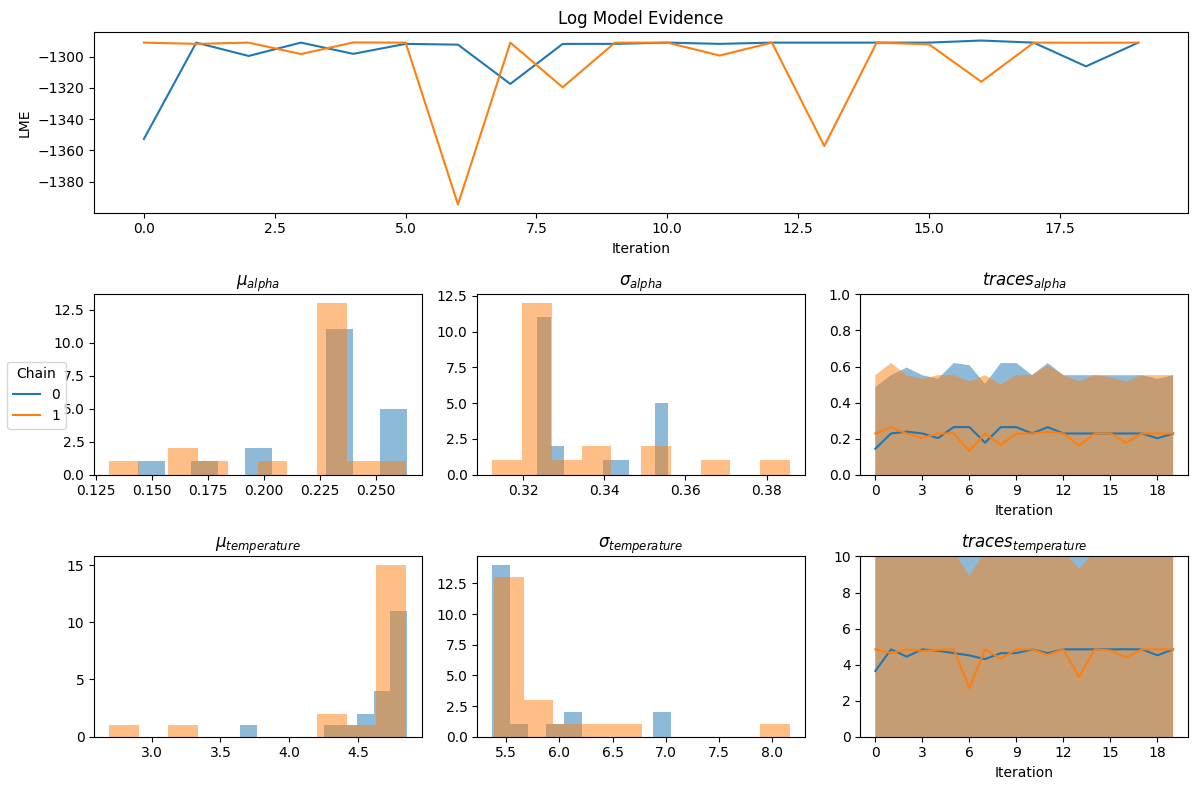

In [63]:
eb.diagnostics()

Next, we will extract the best performing hyperparameters for the priors and reinitialise the model.

In [43]:
hyperparameters = eb.hyperparameters
hyper = hyperparameters[hyperparameters.lme == hyperparameters.lme.max()]
means = [hyper[hyper.parameter == "alpha"].squeeze()['mean'],
         hyper[hyper.parameter == "temperature"].squeeze()['mean']]

ssd = [hyper[hyper.parameter == "alpha"].squeeze()['sd'],
       hyper[hyper.parameter == "temperature"].squeeze()['sd']]

In [45]:
print("Means for learning rate and decision scaling: ", means)
print("Standard deviations for learning rate and decision scaling: ", ssd)

Means for learning rate and decision scaling:  [0.22831061532758423, 4.853229413338457]
Standard deviations for learning rate and decision scaling:  [0.3236249576170432, 5.416253176902918]


In [46]:
## redefine parameters
estimated_parameters = Parameters(
    # freely varying parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args={"mean": means[0], "sd": ssd[0]},
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
        args={"mean": means[1], "sd": ssd[1]},
    ),
    # everything without a prior is part of the initial state of the model or fixed constructs (e.g. exemplars in general-context models of categorization)
    values = np.array([0.25, 0.25, 0.25, 0.25]))

## reinitialise the model
wrapper_with_prior = Wrapper(model=model, parameters=estimated_parameters, data=experiment[experiment.ppt == 1])
fit_with_prior = FminBound(
    model=wrapper,  # Wrapper class with the model we specified from before
    data=experiment,  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    prior=True,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True
)
fit_with_prior.optimise()

Starting optimization 1/5 from [0.78815561 7.93228204]
Starting optimization 2/5 from [0.4303583  3.20883126]
Starting optimization 3/5 from [0.21701328 3.86037493]
Starting optimization 4/5 from [0.58961099 5.0231542 ]
Starting optimization 5/5 from [0.71350608 8.76892116]


In [47]:
from cpm.utils import dict_to_pandas, pandas_to_dict

non_hierarchical = fit.export()
with_hierarchical = fit_with_prior.export()

original = pd.concat(map(lambda x: dict_to_pandas(x), true))

In [60]:
sse = np.sum(np.square(original.alpha.to_numpy() - non_hierarchical.x_0.to_numpy()))
print("Non-hierarchical SSE for parameter recovery: ", sse)

Non-hierarchical SSE for parameter recovery:  6.600148553649561


In [61]:
sse_with_prior = np.sum(np.square(original.alpha.to_numpy() - with_hierarchical.x_0.to_numpy()))
print("Hierarchical SSE for parameter recovery: ", sse_with_prior)

Hierarchical SSE for parameter recovery:  3.111205764611528


Overall, hierarchical models recovered better due to the additional constraints priors imposed on them.